In [1]:
import import_ipynb

from netCDF4 import Dataset
import h5py

In [2]:
# -*- coding: utf-8 -*-
"""
@author: Marybeth Arcodia 
"""

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
import sys
import os 

import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf


#%% Filter
########################################
#interp2.5_hist_1850-1949_PRECT_0.nc
########################################
NLABEL = 2

YEARS = '1850-1949'
STRT = pd.to_datetime('04-01-1850')
END   = pd.to_datetime('07-31-1949')  + dt.timedelta(days=1)

def is_ndjf(month):
    return np.logical_or(month<=2, month>=11)

def is_ndjfm(month):
    return np.logical_or(month<=3, month>=11)

def is_amjj(month):
    return np.logical_and(month>=4, month<=7)

def is_amjja(month):
    return np.logical_and(month>=4, month<=8)

time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_amjj = time_range.where(is_amjj(time_range.month)).dropna()
#TIME_X = xr.DataArray(time_range_amjj + dt.timedelta(days=0), dims=['time'])     
#TIME_Y = xr.DataArray(time_range_amjj + dt.timedelta(days=lead), dims=['time'])  #below comment explains time segmentation

2023-08-10 12:58:23.395648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#-- Pull Parameters from settings.ipynb ------
#Midwest specs 

min_lon = 254 
min_lat = 36 
max_lon = 270 
max_lat = 49 

num_ens = 10

ddir_in = '/Users/marcodia/Research/Data/processed_fields/raw_files_timeconcat/'
ddir_out = '/Users/marcodia/Research/salinity_s2s/'

PREDICTAND_VAR = 'PRECT'
YEARS = '1850-1949'

count = 0
for i in np.arange(0,1):
    infile = 'interp2.5_LE2-'+str(i)+'.'+PREDICTAND_VAR+'.global.'+YEARS+'.nc'       
    X_full = xr.open_dataset(ddir_in+infile)[PREDICTAND_VAR]   #reads in just the PRECT var without the time_bnds dimension 

    X = X_full.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

    X_nptime = np.array(X.time)                 #for some annoying reason, it needed to be converted to numpy for creating DataArray   
    X_nplat = np.array(X.lat)
    X_nplon = np.array(X.lon)
    del infile 

    if count == 0: # don't rewrite empty matrix each time 
        X_all = xr.DataArray(np.zeros((num_ens,X.shape[0],X.shape[1],X.shape[2]))+np.nan,
                             dims = ['ens','time','lat','lon'],
                             coords = [('ens',np.arange(0,num_ens)),('time', X_nptime),('lat',X_nplat),('lon',X_nplon)])
    if PREDICTAND_VAR == 'PRECT':
        X_convert = X * 1000. * 86400. # m/s * 1000mm/m * 86400s/day
        X_all[count,:,:,:] = X_convert
    else:
         X_all[count,:,:,:] = X   
    count = count+1
    del X, X_convert 

In [4]:
X_all.time

<xarray.DataArray 'time' (time: 36500)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1949, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1949-12-31 00:00:00

In [5]:
weights = np.cos(np.deg2rad(X_all.lat))
weights.name = "weights"

lat_weighted = X_all.weighted(weights)
X_dom_avg = lat_weighted.mean(("lon", "lat"))
X_dom_avg

<xarray.DataArray (ens: 10, time: 36500)>
array([[9.54606281e-04, 5.13402868e-01, 2.35008077e+00, ...,
        8.84383577e-03, 4.62995527e-04, 8.39375309e-02],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9
  * time     (time) object 1850-01-01 00:00:00 ... 1949-12-31 00:00:00

In [6]:
# X_dom_avg2 = np.mean(np.mean(X_all,axis=3), axis=2)
# check = X_dom_avg2 - X_dom_avg
# check

In [7]:
# window_size = 3
# i=0

# # Initialize an empty list to store moving averages
# moving_sum = xr.DataArray(np.zeros((num_ens,len(X_dom_avg.time)-window_size)), dims = ['ens','time'],coords = [('ens',np.arange(0,num_ens)),('time', X_nptime[window_size:])])

# for e in np.arange(0,num_ens):
#     # Loop through the array to consider every window of size window_size
#     i=0
#     while i < len(X_all.time) - window_size:

#         window = X_dom_avg[e,i : i + window_size] #  Store elements from i to i+window_size in list to get the current window
#         window_sum = sum(window)

#         #moving_sum.append(window_sum)  # Store the average of current window in moving average list
#         moving_sum[e,i]= window_sum

#         i += 1 #shift window forward by 1 

In [8]:
#moving_sum.to_netcdf('/Users/marcodia/Research/Data/processed_fields/precip_data/'+str(window_size)+'day_sum_precip_midwest_allens_1850-1949.nc')#['PRECT']

In [9]:
window_size = 3
i=0


PREDICTAND_VAR = 'PRECT'
YEARS = '1850-1949'

for e in np.arange(0,1):
    infile = 'interp2.5_LE2-'+str(e)+'.'+PREDICTAND_VAR+'.global.'+YEARS+'.nc'       
    X_full = xr.open_dataset(ddir_in+infile)[PREDICTAND_VAR]   #reads in just the PRECT var without the time_bnds dimension 

    X = X_full.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    X_all = X * 1000. * 86400.
    
    weights = np.cos(np.deg2rad(X_all.lat))
    weights.name = "weights"

    lat_weighted = X_all.weighted(weights)
    X_dom_avg = lat_weighted.mean(("lon", "lat"))
    
    i = 0 
    #X_dom_avg = np.mean(np.mean(X_all,axis=2), axis=1)

    # Initialize an empty list to store moving averages
    moving_sum = xr.DataArray(np.zeros((len(X_dom_avg.time)-window_size)), dims = ['time'],coords = [('time', X_nptime[window_size:])])
    
    # Loop through the array to consider every window of size window_size
    while i < len(X_all.time) - window_size:

        window = X_dom_avg[i : i + window_size] #  Store elements from i to i+window_size in list to get the current window
        window_sum = sum(window)

        #moving_sum.append(window_sum)  # Store the average of current window in moving average list
        moving_sum[i] = window_sum
        
        i += 1 #shift window forward by 1 

    #moving_sum.to_netcdf('/Users/marcodia/Research/Data/processed_fields/precip_data/'+PREDICTAND_VAR+'_midwest_'+YEARS+'_ens'+str(e)+'_'+str(window_size)+'daysum.nc')

In [29]:
moving_sum.time#[0:5]

<xarray.DataArray 'time' (time: 36497)>
array([cftime.DatetimeNoLeap(1850, 1, 4, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 6, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1949, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-04 00:00:00 ... 1949-12-31 00:00:00

In [26]:
sum(X_dom_avg[0:3])

<xarray.DataArray 'PRECT' ()>
array(2.86443824)
Coordinates:
    time     object 1850-01-03 00:00:00

In [28]:
X_dom_avg[0:3].time

<xarray.DataArray 'time' (time: 3)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1850-01-03 00:00:00

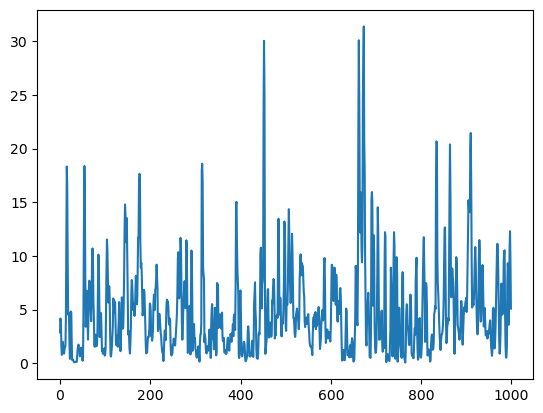

In [12]:
plt.plot(moving_sum[0:1000])

In [28]:
for i in np.arange(0,10):
    print(PREDICTAND_VAR+'_midwest_'+YEARS+'_ens'+str(i)+'_'+str(window_size)+'daysum.nc')

PRECT_midwest_1850-1949_ens0_5daysum.nc
PRECT_midwest_1850-1949_ens1_5daysum.nc
PRECT_midwest_1850-1949_ens2_5daysum.nc
PRECT_midwest_1850-1949_ens3_5daysum.nc
PRECT_midwest_1850-1949_ens4_5daysum.nc
PRECT_midwest_1850-1949_ens5_5daysum.nc
PRECT_midwest_1850-1949_ens6_5daysum.nc
PRECT_midwest_1850-1949_ens7_5daysum.nc
PRECT_midwest_1850-1949_ens8_5daysum.nc
PRECT_midwest_1850-1949_ens9_5daysum.nc


In [16]:
X_all.time

<xarray.DataArray 'time' (time: 36500)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1949, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 1949-12-31 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [39]:
train_list = '12345678'
count = 0
window_size = 5
for i in train_list:
    Ytrain_finame = 'PRECT_midwest_1850-1949_ens'+str(i)+'_'+str(window_size)+'daysum.nc'

    Y_all_full = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/precip_data/'+Ytrain_finame)
    Y = Y_all_full#.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        Y_all = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])
        
        
    Y_all[count,:] = Y   
    count = count + 1

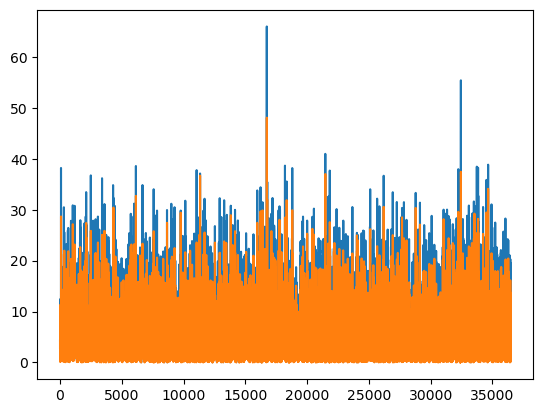

In [41]:
plt.plot(Y_all[0,:])
plt.plot(Y_all3[0,:])

In [40]:
train_list = '12345678'
count = 0
for i in train_list:
    Ytrain_finame = 'PRECT_midwest_1850-1949_ens'+str(i)+'_'+str(3)+'daysum.nc'

    Y_all_full = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/precip_data/'+Ytrain_finame)
    Y = Y_all_full#.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        Y_all3 = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])
        
        
    Y_all3[count,:] = Y   
    count = count + 1

In [ ]:
for i in np.arange(0,10):
    plt.hist(moving_sum[i,:])
    plt.xlabel('mm/day')
    plt.ylabel('# of days')

In [ ]:
max(moving_sum[2,:])

In [ ]:
np.percentile(moving_sum[2,:],40)

In [ ]:
np.percentile(moving_sum[2,:],80)

In [ ]:
np.percentile(moving_sum[2,:],100)

In [ ]:
# # Distribution of precip concentrations

# fig, axs = plt.subplots(2, 4, figsize = (15,8))

# for m in np.arange(0,8):
#     ax = axs[m//4,m%4]
# #    sb.displot(Y_all[m,:], kind='hist')
#     sb.histplot(Y_all[m,:], color='black', ax=ax)
#     ax.set(xticks=(np.arange(0,55,step=5)))

#     ax.set_xlabel('mm')
#     Y_use = Y_all[m,:]
#     light_val = np.percentile(Y_use, 40)
#     mod_val   = np.percentile(Y_use,80)
    
#     ax.axvline(x=light_val, color='goldenrod')
#     ax.axvline(x=mod_val, color='red')
#     ax.set_title('Training Ensemble Member '+str(m+1))
#     ax.text(8, 50, 'Light', rotation=90, color='goldenrod')
#     ax.text(16, 50, 'Moderate', rotation=90, color='red')

# fig.tight_layout(pad=1.0)
# print('Histograms of Midwest Summer Precip 5-day Sums')

